In [1]:
from src.esn import ESN
from src.utils import config, helper
from src.conceptors import compute_conceptor, loading_ridge_report, compute_conceptor_diag, ridge_regression

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Random Feature Conceptors
pattern retrieval with stored conceptor

## Without adaptation (does not work... from time to time...)

In [3]:
prng = np.random.default_rng(1234)

In [4]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1.4,
    #init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    #init_weights_density=0.1,
    init_weights_in_density=1.0,
    #init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1.4},
    
    random_feature=True,
    random_feature_size=500,
    init_weights_g_density=1.0,
    init_weights_f_density=1.0,
    init_weights_g='normal',
    init_weights_f='normal',
    init_weights_g__args={'loc': 0., 'scale': 1.},
    init_weights_f__args={'loc': 0., 'scale': 1.},
    
)

In [5]:
T_pattern = 6000
ut = [
    helper.n_periodic(5, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(5, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [6]:
T_WASHOUT = 200
LOADING_REGULARIZER_D = 1e-2
LOADING_REGULARIZER_G = 1e-2
LOADING_REGULARIZER_Wout = 1
APERTURE = 5

In [7]:
esn = ESN(esnConfig, prng)

In [8]:
xt, zt, yt = list(zip(*map(esn.harvest_states, ut)))
# concatenate patterns along time
X = helper.concatenate_patterns(xt, T_WASHOUT)
U = helper.concatenate_patterns(ut, T_WASHOUT)

In [9]:
Y_T = U.copy()
esn.update_weights(X, U, Y_T, alpha=LOADING_REGULARIZER_Wout)

In [10]:
xt_conceptor, zt_conceptor, yt_trained = list(zip(*map(esn.harvest_states, ut)))

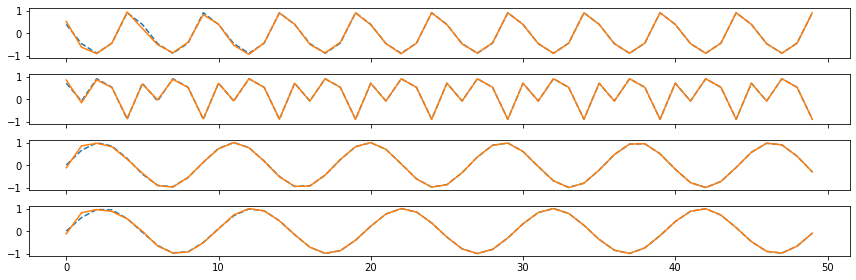

In [11]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:50], ls='--')
    ax[i].plot(yt_trained[i][:50])
plt.tight_layout()

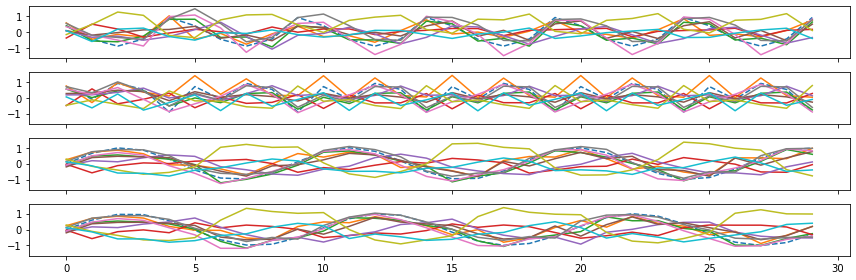

In [12]:
# Plot of the reservoir expanded
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:30], ls='--')
    ax[i].plot(zt_conceptor[i][:30][:,1:10])
plt.tight_layout()

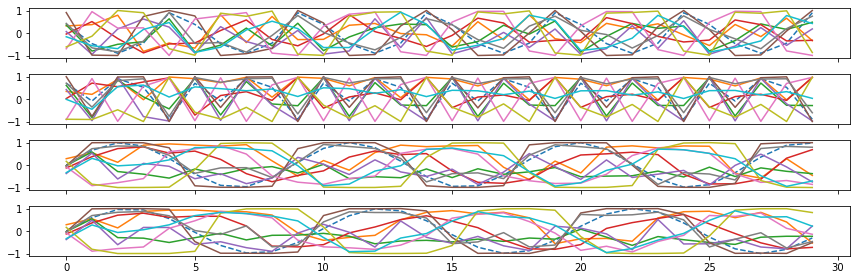

In [13]:
# Plot of the reservoir
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][:30], ls='--')
    ax[i].plot(xt_conceptor[i][:30][:,1:10])
plt.tight_layout()

In [14]:
Z_ = helper.concatenate_patterns(zt, T_WASHOUT, shift=-1)
Z = helper.concatenate_patterns(zt, T_WASHOUT, shift=0)

In [15]:

D_loaded = ridge_regression(Z_, np.dot(esn.w_in, U.T).T, regularizer=LOADING_REGULARIZER_D)
G_loaded = ridge_regression(Z, np.dot(esn.g, Z.T).T, regularizer=LOADING_REGULARIZER_G)
esn.g = G_loaded + D_loaded.copy()
"""

G_loaded = ridge_regression(Z_, (np.dot(esn.g, Z_.T) + np.dot(esn.w_in, U.T)).T, regularizer=LOADING_REGULARIZER_G)
esn.g = G_loaded"""

'\n\nG_loaded = ridge_regression(Z_, (np.dot(esn.g, Z_.T) + np.dot(esn.w_in, U.T)).T, regularizer=LOADING_REGULARIZER_G)\nesn.g = G_loaded'

In [16]:
Ci = [
    np.diag(compute_conceptor_diag(zt_i[T_WASHOUT:, :], aperture=APERTURE)).reshape(-1, 1)
    for zt_i in zt
]

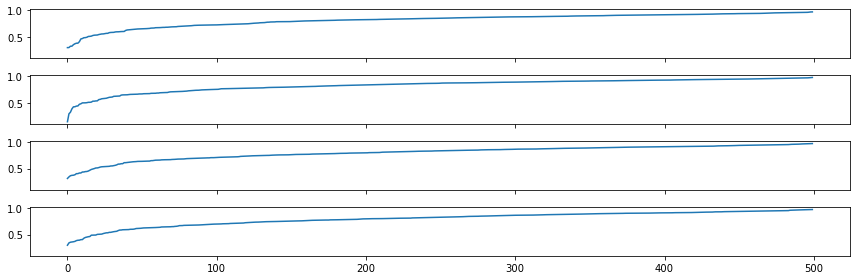

In [17]:
# Monitor the scaling values of C
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(np.sort(Ci[i][:,0]))
plt.tight_layout()

In [18]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
z_init = prng.uniform(low=-1., high=1., size=(esn.random_feature_size, 1))
xt_conceptor, zt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), z_init=z_init.copy(),   C=Ci[i])
    for i in range(len(ut))
]))

In [19]:
t_ini=1950
t_final=2000

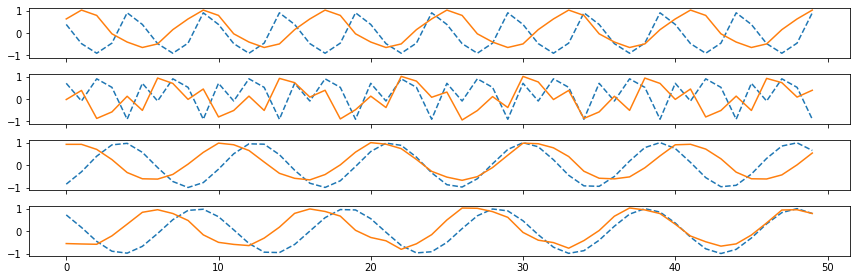

In [20]:
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][t_ini:t_final], ls='--')
    ax[i].plot(yt_conceptor[i][t_ini:t_final])
plt.tight_layout()

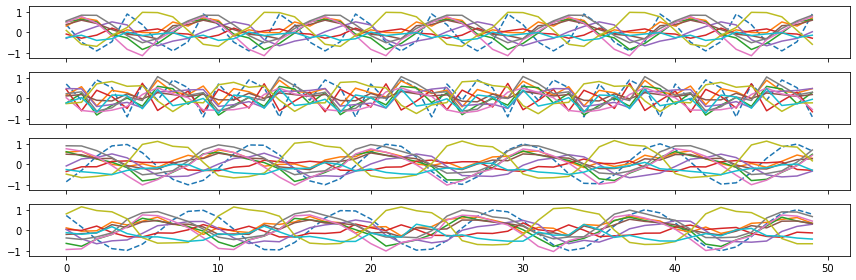

In [21]:
# Plot of the reservoir expanded
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][t_ini:t_final], ls='--')
    ax[i].plot(zt_conceptor[i][t_ini:t_final][:,1:10])
plt.tight_layout()

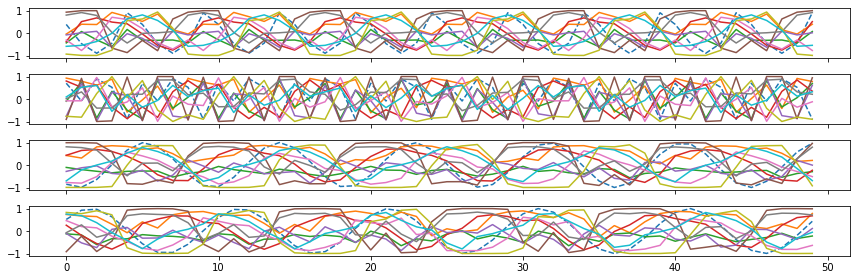

In [22]:
# Plot of the reservoir
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][50:100], ls='--')
    ax[i].plot(xt_conceptor[i][t_ini:t_final][:,1:10])
plt.tight_layout()

# full_procedure (in one step using trainingConfig)

In [23]:
prng = np.random.default_rng(1234)


In [24]:
trainingConfig = config.TrainingConfig(
    washout=200,
    aperture=14,
    w_regularizer=1e-1,
    g_regularizer=1e-1,
    d_regularizer=1e-1,
    wout_regularizer=0.1
)

In [25]:
esnConfig = config.ESNConfig(
    input_size=1,
    reservoir_size=100,
    output_size=1,
    feedback=False,
    spectral_radius=1.4,
    #init_weights='normal',
    init_weights_b='normal',
    init_weights_in='normal',
    #init_weights_density=0.1,
    init_weights_in_density=1.0,
    #init_weights__args={'loc': 0., 'scale': 1.},
    init_weights_b__args={'loc': 0., 'scale': 0.2},
    init_weights_in__args={'loc': 0., 'scale': 1},
    
    random_feature=True,
    random_feature_size=500,
    init_weights_g_density=1.0,
    init_weights_f_density=1.0,
    init_weights_g='normal',
    init_weights_f='normal',
    init_weights_g__args={'loc': 0., 'scale': 1.},
    init_weights_f__args={'loc': 0., 'scale': 1.},
    
)

In [26]:
T_pattern = 2500
ut = [
    helper.n_periodic(5, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(5, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [27]:
esn = ESN(esnConfig, prng)

In [28]:
Ci = esn.full_procedure(ut, trainingConfig)

In [29]:
ut_zero = np.zeros_like(ut[0])
x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
z_init = prng.uniform(low=-1., high=1., size=(esn.random_feature_size, 1))
xt_conceptor, zt_conceptor, yt_conceptor = list(zip(*[
    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), z_init=z_init.copy(),   C=Ci[i])
    for i in range(len(ut))
]))

In [30]:
t_ini=1950
t_final=2000

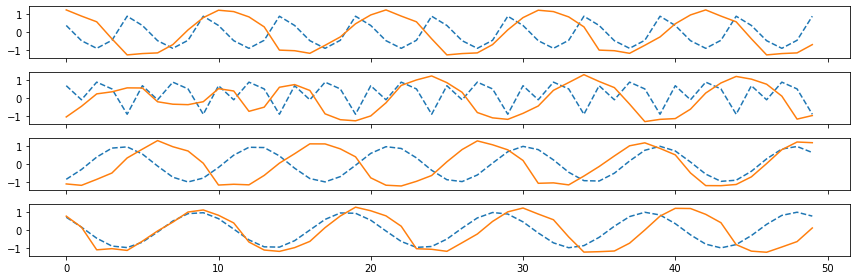

In [31]:
t_ini=1950
t_final=2000
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][t_ini:t_final], ls='--')
    ax[i].plot(yt_conceptor[i][t_ini:t_final])
plt.tight_layout()

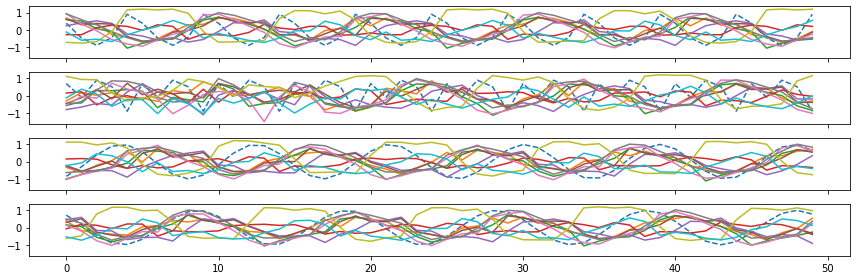

In [32]:
# Plot of the reservoir expanded
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][t_ini:t_final], ls='--')
    ax[i].plot(zt_conceptor[i][t_ini:t_final][:,1:10])
plt.tight_layout()

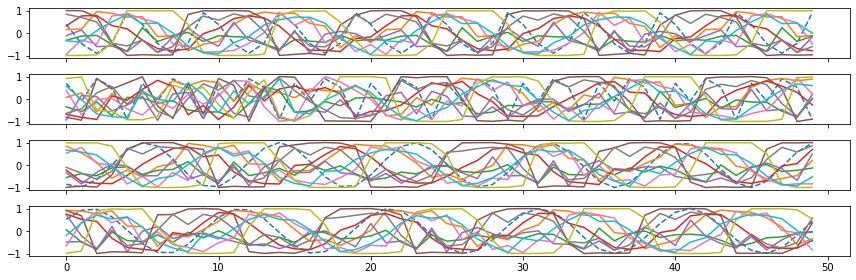

In [33]:
# Plot of the reservoir
fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
for i in range(len(ut)):
    ax[i].plot(ut[i][50:100], ls='--')
    ax[i].plot(xt_conceptor[i][t_ini:t_final][:,1:10])
plt.tight_layout()

In [35]:
RMSE, _ = helper.testLRMSE(ut, yt_conceptor, 10,20)

# Hyperpara search

In [37]:
T_pattern = 2500
ut = [
    helper.n_periodic(5, T_pattern, np.random.default_rng(27)),
    helper.n_periodic(5, T_pattern, np.random.default_rng(42)),
    helper.n_sine(8.83, T_pattern, phase=0.),
    helper.n_sine(9.83, T_pattern, phase=0.)
]

In [38]:
N = 100
Winscal = [1.2,1.4,1]
SpecRadius = [0.6,1,1.4,2]
Apertj = [1,6,8,10,14]

b_scal = [0.1,0.2,0.4]
Wout_reg = [0,1e-1,1e-2,1e-3]
G_reg = [0,1e-1,1e-2,1e-3]
D_reg = [0,1e-1,1e-2,1e-3]


T_WASHOUT = 200
T_ADAPT = 500
T_LEARN = 5000 - 200 - 500


In [39]:
L_RMSE = []
def hyperparasearch (Winscal, b_scal, Wout_reg, SpecRadius, Apertj, N, ut, G_reg, D_reg, T_WASHOUT, T_ADAPT, T_LEARN):
    for b in b_scal:
        for win in Winscal:
            for rad in SpecRadius:
                for wout in Wout_reg:
                    for g in G_reg:
                        for d in D_reg:
                            for aj in Apertj: 
                                prng = np.random.default_rng(1234)
                                print("aj: "+str(aj)+", b: "+str(b)+",wout:  "+str(wout)+", rad: "+str(rad), ", g:" + str(g) +
                                     ", d:" + str(d) + ",win : "+str(win))
                                # Initialization
                                esnConfig = config.ESNConfig(
                                    input_size=1,
                                    reservoir_size=N,
                                    output_size=1,
                                    feedback=False,
                                    spectral_radius=rad,
                                    #init_weights='normal',
                                    init_weights_b='normal',
                                    init_weights_in='normal',
                                    #init_weights_density=0.1,
                                    init_weights_in_density=1.0,
                                    #init_weights__args={'loc': 0., 'scale': 1.},
                                    init_weights_b__args={'loc': 0., 'scale': b},
                                    init_weights_in__args={'loc': 0., 'scale': win},

                                    random_feature=True,
                                    random_feature_size=500,
                                    init_weights_g_density=1.0,
                                    init_weights_f_density=1.0,
                                    init_weights_g='normal',
                                    init_weights_f='normal',
                                    init_weights_g__args={'loc': 0., 'scale': 1.},
                                    init_weights_f__args={'loc': 0., 'scale': 1.},
                                )

                                trainingConfig = config.TrainingConfig(
                                    washout=200,
                                    aperture=aj,
                                    g_regularizer=g,
                                    d_regularizer=d,
                                    wout_regularizer=wout
                                    )

                                esn = ESN(esnConfig, prng)
                                Ci = esn.full_procedure(ut, trainingConfig)

                                ut_zero = np.zeros_like(ut[0])
                                x_init = prng.uniform(low=-1., high=1., size=(esn.reservoir_size, 1))
                                z_init = prng.uniform(low=-1., high=1., size=(esn.random_feature_size, 1))
                                xt_conceptor, zt_conceptor, yt_conceptor = list(zip(*[
                                    esn.harvest_states(ut_zero.copy(), x_init=x_init.copy(), z_init=z_init.copy(),   C=Ci[i])
                                    for i in range(len(ut))
                                ]))
                                """
                                t_ini=1950
                                t_final=2000
                                fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
                                for i in range(len(ut)):
                                    ax[i].plot(ut[i][t_ini:t_final], ls='--')
                                    ax[i].plot(yt_conceptor[i][t_ini:t_final])
                                plt.tight_layout()"""

                                RMSE, _ = helper.testLRMSE(ut, yt_conceptor, 10,20)
                                
                                L_RMSE.append([np.mean(RMSE), "aj: "+str(aj)+", b: "+str(b)+",wout:  "+str(wout)+", rad: "+str(rad), ", g:" + str(g) +
                                     ", d:" + str(d) + ",win : "+str(win)])
                                """
                                # Monitor the scaling values of C
                                fig, ax = plt.subplots(len(ut), 1, figsize=(12, len(ut)), sharex=True, sharey=True)
                                for i in range(len(ut)):
                                    ax[i].plot(np.sort(Ci[i][:,0]))
                                plt.tight_layout()
                                plt.show()
                                """
                                print(RMSE, np.mean(RMSE))

In [40]:
hyperparasearch(Winscal, b_scal, Wout_reg, SpecRadius, Apertj, N, ut, G_reg, D_reg, T_WASHOUT, T_ADAPT, T_LEARN)

aj: 1, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0,win : 1.2
[6.703614700605819, 5.937129052998852, 9.612814852820742, 13.596198445969335] 8.962439263098688
aj: 6, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0,win : 1.2
[7.528105753346624, 6.380294685842795, 5.050619752808203, 6.491268421358686] 6.3625721533390776
aj: 8, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0,win : 1.2
[7.420325962480073, 4.125131620549614, 6.4816123260299445, 4.491025963218034] 5.629523968069417
aj: 10, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0,win : 1.2
[6.340031537150091, 6.378910472839619, 4.916719666458631, 5.868196879627487] 5.8759646390189575
aj: 14, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0,win : 1.2
[4.873790993357481, 5.003043392964019, 4.996440359733727, 4.750376038613217] 4.9059126961671105
aj: 1, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0.1,win : 1.2
[11.028048559377186, 8.524662786009802, 12.200334820737364, 11.808822089430354] 10.890467063888677
aj: 6, b: 0.1,wout:  0, rad: 0.6 , g:0, d:0.1,win : 1.2
[3.748557146329858, 6.440216640550275

[2.0094892423315307, 1.0270755304191934, 1.0018312987035118, 1.0167333347322005] 1.2637823515466091
aj: 14, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[1.723256619505807, 1.090448346229197, 0.6842118946255195, 0.33177213769434444] 0.9574222495137169
aj: 1, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[0.9385500998607064, 0.8552928471595833, 0.9246201834084127, 0.9309579541877633] 0.9123552711541164
aj: 6, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[2.8318964044587385, 1.456964668641897, 1.6153309463520986, 1.6683021953042143] 1.8931235536892372
aj: 8, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[2.148314543562588, 1.6239510669475448, 0.7727988471211884, 1.0601197139016043] 1.4012960428832315
aj: 10, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[1.6955799799997116, 1.3892088375380944, 0.7604047467669868, 0.9788205282806791] 1.206003523146368
aj: 14, b: 0.1,wout:  0, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[1.3160204898806618, 1.3312323298677

[0.943229601622515, 0.8916413100163851, 0.9856659250324629, 0.9710381297960313] 0.9478937416168486
aj: 6, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[2.2741678719100475, 0.9909484176843862, 2.1216255269278275, 2.19569921206333] 1.8956102571463977
aj: 8, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[2.0402768054410974, 0.8964427874953296, 1.749487049732073, 1.7967325225351223] 1.6207347913009056
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[1.79473073650786, 0.869242101889317, 1.486265195949108, 1.5227234535198617] 1.4182403719665366
aj: 14, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[1.4461495677972158, 1.2330213056941806, 0.9205319328659249, 0.958708483973137] 1.1396028225826147
aj: 1, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.01,win : 1.2
[0.9269636958544338, 0.8600381723095927, 0.9582469103335443, 0.9509994703925216] 0.9240620622225231
aj: 6, b: 0.1,wout:  0.1, rad: 0.6 , g:0.1, d:0.01,win : 1.2
[2.8604463777265927, 0.952832416007432, 2.128

[2.1411137772392688, 1.634610553471206, 0.8799548388644569, 1.1340468406481272] 1.447431502555765
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , g:0.001, d:0.001,win : 1.2
[1.511752769995578, 1.3668184200772755, 0.7556442941947613, 0.9636239510158602] 1.1494598588208687
aj: 14, b: 0.1,wout:  0.1, rad: 0.6 , g:0.001, d:0.001,win : 1.2
[1.4126260449980728, 1.2282606798106683, 0.8756400871962577, 0.80351014460499] 1.0800092391524974
aj: 1, b: 0.1,wout:  0.01, rad: 0.6 , g:0, d:0,win : 1.2
[4.174437499839941, 2.8072041434295087, 6.486520252862251, 8.303563846399662] 5.442931435632841
aj: 6, b: 0.1,wout:  0.01, rad: 0.6 , g:0, d:0,win : 1.2
[4.127876588575531, 3.49285630425175, 2.5734227741397637, 3.180111279731351] 3.343566736674599
aj: 8, b: 0.1,wout:  0.01, rad: 0.6 , g:0, d:0,win : 1.2
[3.996620625236484, 2.5214959748007706, 2.7349168638832135, 1.8088866509354076] 2.765480028713969
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , g:0, d:0,win : 1.2
[3.817529865668568, 2.2935242451006426, 2.865815689043745

[1.4709795077052172, 1.2762076631487296, 1.1043823613616923, 1.0369323143075075] 1.2221254616307866
aj: 1, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[0.9327767422620215, 0.8628419016090842, 0.9616812349493471, 0.953417631215542] 0.9276793775089986
aj: 6, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[2.797002537066063, 1.0185325293963257, 2.0277408092922715, 2.09563603890796] 1.984727978665655
aj: 8, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[2.5177944151255067, 1.0136363161972055, 1.5381428143932854, 1.6180043895158192] 1.6718944838079541
aj: 10, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[2.037374877064858, 1.0253806892232435, 1.024422061923246, 1.0420933273384825] 1.2823177388874574
aj: 14, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.01,win : 1.2
[1.7336432807386961, 1.099982730259209, 0.6563206260053104, 0.3116129266875287] 0.950389890922686
aj: 1, b: 0.1,wout:  0.01, rad: 0.6 , g:0.01, d:0.001,win : 1.2
[0.9452455687676182, 0.85407

[12.797561644912864, 12.871095567226465, 12.43562560762632, 12.819582498849531] 12.730966329653796
aj: 6, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0,win : 1.2
[12.578435832657224, 12.655580535522958, 12.27293056205784, 12.655689109232046] 12.540659009867518
aj: 8, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0,win : 1.2
[12.583382398986105, 12.658693694724992, 12.303940831433877, 12.687971934047027] 12.558497214798
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0,win : 1.2
[12.597652632006481, 12.672450558625748, 12.355411131948788, 12.741700502573021] 12.591803706288509
aj: 14, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0,win : 1.2
[12.673275561810739, 12.775777509864135, 12.422381471766137, 12.786924107120136] 12.664589662640287
aj: 1, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[0.9585138565792102, 0.8988342007189398, 0.9981270317117183, 0.983269772926988] 0.9596862154842141
aj: 6, b: 0.1,wout:  0.001, rad: 0.6 , g:0.1, d:0.1,win : 1.2
[2.295552635273366, 0.9995942204562183, 

[2.8959818673976896, 0.9423203031790637, 2.132768364442849, 2.1763565511165455] 2.036856771534037
aj: 8, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.01,win : 1.2
[2.6386661008343557, 0.9598199432994686, 1.626533882069526, 1.6687269139811851] 1.7234367100461339
aj: 10, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.01,win : 1.2
[2.1067645443444496, 0.9315075411097348, 1.0877446745433275, 1.0571771612256882] 1.2957984803058
aj: 14, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.01,win : 1.2
[1.7066332358584655, 1.0236444584619426, 0.8735987664476896, 0.8037647792732193] 1.1019103100103294
aj: 1, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.001,win : 1.2
[0.9483246661718944, 0.8476241364421644, 0.9162377502014196, 0.9332780323809763] 0.9113661462991137
aj: 6, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.001,win : 1.2
[2.957390039285629, 1.5266370263224625, 1.7211085105714385, 1.7922828831212931] 1.9993546148252057
aj: 8, b: 0.1,wout:  0.001, rad: 0.6 , g:0.001, d:0.001,win : 1.2
[2.178764103

[7.0302966218533935, 4.903330410667776, 5.83154100191059, 6.3493653245489945] 6.028633339745189
aj: 1, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.8453387812341482, 0.8944253232984343, 0.9157604369969453, 0.9354282514942476] 0.8977381982559438
aj: 6, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.9268623100077757, 1.2457624786317205, 0.9606785601431527, 1.219696491021176] 1.0882499599509563
aj: 8, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.7747201882280255, 1.3145395836642688, 1.361637640534086, 1.3943019394895226] 1.211299837978976
aj: 10, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.497167976038453, 0.8278536744192353, 1.3967639927577815, 1.4482072221121114] 1.0424982163318952
aj: 14, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.512908605858237, 1.302061171241404, 1.4207425155842306, 0.7543796584042854] 0.9975229877720393
aj: 1, b: 0.1,wout:  0, rad: 1 , g:0.01, d:0.01,win : 1.2
[0.8570633574821103, 0.8820376450215961, 0.923852239517658, 0.944

[0.787285500550919, 0.9979650082019926, 0.953195533992067, 0.9234817061417362] 0.9154819372216787
aj: 10, b: 0.1,wout:  0.1, rad: 1 , g:0, d:0.001,win : 1.2
[0.7826137107496643, 0.9266110852358534, 0.9189950591971501, 1.0206007232003365] 0.9122051445957511
aj: 14, b: 0.1,wout:  0.1, rad: 1 , g:0, d:0.001,win : 1.2
[0.8751829331014433, 0.8508030617391478, 0.8319900904218529, 0.8639263853460593] 0.8554756176521259
aj: 1, b: 0.1,wout:  0.1, rad: 1 , g:0.1, d:0,win : 1.2
[5.417570572114955, 4.177458268679434, 5.2672466196217345, 5.525957063931802] 5.097058131086981
aj: 6, b: 0.1,wout:  0.1, rad: 1 , g:0.1, d:0,win : 1.2
[6.071224572397394, 4.13342884651694, 4.9913783494669355, 5.460348496085496] 5.164095066116692
aj: 8, b: 0.1,wout:  0.1, rad: 1 , g:0.1, d:0,win : 1.2
[6.071194329366406, 4.133133315514404, 4.989651671197755, 5.458403486645494] 5.163095700681015
aj: 10, b: 0.1,wout:  0.1, rad: 1 , g:0.1, d:0,win : 1.2
[6.071198049538522, 4.13301113379446, 4.989038743700146, 5.45773683654127

[0.8384285172723756, 0.914487104954936, 0.9183951107797204, 0.9443205843633647] 0.9039078293425992
aj: 6, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.24907293850677548, 0.7089081889024575, 1.5504708952412618, 1.267743704687133] 0.944048931834407
aj: 8, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.15136976340551883, 0.962226300888524, 1.5607216026521562, 1.4666346244057058] 1.0352380728379762
aj: 10, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.12753155104166244, 1.1607815488915434, 1.6108387748910364, 1.3076135684586676] 1.0516913608207274
aj: 14, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.4343935945588367, 1.265871946807812, 1.9149925115031303, 2.0253650414706783] 1.4101557735851142
aj: 1, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.001,win : 1.2
[0.8425295799707516, 0.9026840753268501, 0.9177720901538815, 0.9355604285881183] 0.8996365435099003
aj: 6, b: 0.1,wout:  0.1, rad: 1 , g:0.001, d:0.001,win : 1.2
[0.2781264196310139, 0.855500106

[6.487129737179279, 4.465055550480671, 5.353914951090973, 5.844521746776724] 5.537655496381912
aj: 10, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0,win : 1.2
[6.487137403603922, 4.464778485783741, 5.35260728997244, 5.843107937850167] 5.536907779302568
aj: 14, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0,win : 1.2
[6.487204631775172, 4.464563871644204, 5.351703110039217, 5.84214997372376] 5.536405396795589
aj: 1, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.8301482149863477, 0.9338116462197108, 0.9137711366315914, 0.9378262799090036] 0.9038893194366633
aj: 6, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.9314727708062533, 1.28381149868106, 0.9800445237877334, 1.2561741245924525] 1.1128757294668747
aj: 8, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.768106914797582, 1.3390851855748962, 1.3389285049878337, 1.4216448179115897] 1.2169413558179754
aj: 10, b: 0.1,wout:  0.01, rad: 1 , g:0.01, d:0.1,win : 1.2
[0.4499773052641958, 0.8526788475559475, 1.3465930392098757, 

[0.8958833006230513, 1.0247999981776057, 1.067702904493848, 0.8594103581322299] 0.9619491403566838
aj: 1, b: 0.1,wout:  0.001, rad: 1 , g:0, d:0.001,win : 1.2
[0.9205478535299381, 0.9650914569993793, 1.0882805721529771, 1.0918101170389374] 1.0164324999303078
aj: 6, b: 0.1,wout:  0.001, rad: 1 , g:0, d:0.001,win : 1.2
[0.8114652598246956, 1.0144802292978692, 1.055576365695233, 1.0176652947707159] 0.9747967873971285
aj: 8, b: 0.1,wout:  0.001, rad: 1 , g:0, d:0.001,win : 1.2
[0.8181635913061407, 1.0482337352104456, 0.9939122521022611, 0.9391462732871767] 0.949863962976506
aj: 10, b: 0.1,wout:  0.001, rad: 1 , g:0, d:0.001,win : 1.2
[0.764464305331312, 0.9650315357412451, 1.005557847963822, 1.1243247864479544] 0.9648446188710834
aj: 14, b: 0.1,wout:  0.001, rad: 1 , g:0, d:0.001,win : 1.2
[0.89779746253974, 0.8945939491455002, 0.947782991782141, 0.9929171816597164] 0.9332728962817743
aj: 1, b: 0.1,wout:  0.001, rad: 1 , g:0.1, d:0,win : 1.2
[6.48698042677134, 5.165912563680437, 6.37083869

[0.6918828785159785, 1.286698598010199, 0.9969666935438941, 1.3395862716653912] 1.0787836104338657
aj: 8, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.1,win : 1.2
[0.7262444847221181, 1.3952600424351957, 1.428691876616671, 1.4750064181345923] 1.2563007054771442
aj: 10, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.1,win : 1.2
[0.34656147368263335, 0.9360882990099534, 1.5619258607490698, 1.4334926602418623] 1.0695170734208796
aj: 14, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.1,win : 1.2
[0.35679513432432414, 1.6437910097552764, 1.7064194207104852, 1.5618459174074821] 1.317212870549392
aj: 1, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.8405941994167687, 0.9103696956509228, 0.9188356668198523, 0.943854674244877] 0.9034135590331052
aj: 6, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.25014820363826873, 0.708687722191403, 1.555163351997007, 1.2689528477520753] 0.9457380313946885
aj: 8, b: 0.1,wout:  0.001, rad: 1 , g:0.001, d:0.01,win : 1.2
[0.15513522159263118, 0.96

[1.1913425865485952, 1.4752907757131397, 0.19380236409122995, 0.3843426648842065] 0.8111945978092928
aj: 14, b: 0.1,wout:  0, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[1.3043910548665456, 1.550053295696738, 0.4888435643105109, 0.4849655121299409] 0.9570633567509339
aj: 1, b: 0.1,wout:  0, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.4592974343001224, 3.5536089986197688, 3.3272987305063095, 3.4653550836347025] 3.451390061765226
aj: 6, b: 0.1,wout:  0, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.4745774923063246, 3.553317231803577, 3.347268055292953, 3.554521774074578] 3.482421138369358
aj: 8, b: 0.1,wout:  0, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.47454884592532, 3.552397382832977, 3.347101841066887, 3.553916069658877] 3.4819910348710152
aj: 10, b: 0.1,wout:  0, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.4744584592627845, 3.5516279437714378, 3.346828575642081, 3.553424827072873] 3.481584951437294
aj: 14, b: 0.1,wout:  0, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.4740157580430995, 3.5506872324537273, 3.3461054768412444, 3.55

[0.8680311956575818, 0.9765532502210708, 1.267510584153844, 1.0336744896066894] 1.0364423799097966
aj: 6, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.8389289764750723, 0.9600311229652995, 0.8604452268426188, 1.0615376261722433] 0.9302357381138084
aj: 8, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.7741982538280248, 0.9784177621414071, 0.9030342625408638, 0.9206874665747331] 0.8940844362712571
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.8444387195644337, 0.8172645177658072, 1.002284244495479, 0.9351157174139357] 0.8997757998099138
aj: 14, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.6985820579745787, 0.871446960594197, 0.9034653220594928, 0.9320310199098019] 0.8513813401345176
aj: 1, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.001,win : 1.2
[0.8894451841542905, 0.9716797142478655, 1.2696399721980178, 1.0335463351993457] 1.0410778014498798
aj: 6, b: 0.1,wout:  0.1, rad: 1.4 , g:0, d:0.001,win : 1.2
[0.7434451355862735, 0.9135237426670046, 0.97

[4.658101464527324, 4.735660143446777, 4.493846766844218, 4.73169705572351] 4.654826357635457
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0,win : 1.2
[4.65798692004337, 4.734772109397924, 4.493516580425406, 4.731142125800286] 4.654354433916747
aj: 14, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0,win : 1.2
[4.65744950041881, 4.7336899051602, 4.492658077900106, 4.730426822001063] 4.653556076370045
aj: 1, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0.1,win : 1.2
[0.8020751510500607, 0.9740692982145396, 0.9117605668220647, 0.9623288203987941] 0.9125584591213648
aj: 6, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0.1,win : 1.2
[1.295484499593143, 1.3151215801928933, 0.17393006549179318, 0.5457499425879017] 0.8325715219664328
aj: 8, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0.1,win : 1.2
[1.3378027461818367, 1.2599134530924099, 0.30942145364336543, 0.28173470106084614] 0.7972180884946145
aj: 10, b: 0.1,wout:  0.1, rad: 1.4 , g:0.001, d:0.1,win : 1.2
[1.0745081002484973, 1.4459797335057822, 0.1562

[1.2572571850695489, 1.6602137067741682, 0.54812049678243, 0.8902431577726272] 1.0889586365996935
aj: 1, b: 0.1,wout:  0.01, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[0.8447035101170974, 1.0053886577013003, 0.9247576631566914, 0.9841436963720263] 0.9397483818367789
aj: 6, b: 0.1,wout:  0.01, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[1.356351975655557, 1.1298722668761894, 0.0954989400172602, 0.49710721803716146] 0.769707600146542
aj: 8, b: 0.1,wout:  0.01, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[1.1947255564180468, 1.2796698976071572, 0.20261051469883284, 0.45008354758184577] 0.7817723790764707
aj: 10, b: 0.1,wout:  0.01, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[1.2071204440386352, 1.4789096548715266, 0.18290162343433575, 0.36599647919753364] 0.8087320503855078
aj: 14, b: 0.1,wout:  0.01, rad: 1.4 , g:0.1, d:0.001,win : 1.2
[1.3114813747454896, 1.5697527751687304, 0.466078064792107, 0.4602368926129921] 0.9518872768298298
aj: 1, b: 0.1,wout:  0.01, rad: 1.4 , g:0.01, d:0,win : 1.2
[3.8767207687918006, 3.

[0.9131649172113969, 1.0601523084149287, 1.4385819050015183, 1.0854329154067914] 1.1243330115086587
aj: 6, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.1,win : 1.2
[0.9234444624181783, 0.9388651999254756, 0.9846035056426876, 0.9858133081476178] 0.9581816190334899
aj: 8, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.1,win : 1.2
[0.9523430129779257, 1.04221959179166, 0.9251010216296679, 1.0719370372072006] 0.9979001659016136
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.1,win : 1.2
[0.9376167720583839, 0.9538186299494031, 0.9826577486679114, 1.0577559514708736] 0.982962275536643
aj: 14, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.1,win : 1.2
[0.8467320694733311, 1.1328735685353202, 0.9378388423102442, 0.9531311887493189] 0.9676439172670536
aj: 1, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.9205075060061649, 1.066919837696569, 1.3895051249898391, 1.0841184086983868] 1.11526271934774
aj: 6, b: 0.1,wout:  0.001, rad: 1.4 , g:0, d:0.01,win : 1.2
[0.9403472178211401, 1.0407407981476342, 0

[1.267042946747412, 0.7498519348882813, 0.3607968518479123, 0.5130311731991813] 0.7226807266706967
aj: 8, b: 0.1,wout:  0.001, rad: 1.4 , g:0.01, d:0.001,win : 1.2
[1.3244835374102468, 0.7525455694793783, 0.5276778014253342, 0.9245674526999466] 0.8823185902537265
aj: 10, b: 0.1,wout:  0.001, rad: 1.4 , g:0.01, d:0.001,win : 1.2
[1.026912635592724, 0.6986234466697041, 0.6537380516002778, 0.7575723533104846] 0.7842116217932976
aj: 14, b: 0.1,wout:  0.001, rad: 1.4 , g:0.01, d:0.001,win : 1.2
[1.349488099882717, 0.9730721490548389, 0.871865748397572, 1.055460624155089] 1.0624716553725544
aj: 1, b: 0.1,wout:  0.001, rad: 1.4 , g:0.001, d:0,win : 1.2
[3.5178857177948313, 3.613089359620335, 3.383451767236239, 3.519745939254669] 3.5085431959765185
aj: 6, b: 0.1,wout:  0.001, rad: 1.4 , g:0.001, d:0,win : 1.2
[3.534097061719087, 3.612767550174065, 3.404745456039157, 3.613554404719623] 3.5412911181629827
aj: 8, b: 0.1,wout:  0.001, rad: 1.4 , g:0.001, d:0,win : 1.2
[3.5340653334330128, 3.611761

[1.086801491582606, 0.8706806788535857, 0.6364527065521508, 0.387174414107238] 0.7452773227738951
aj: 14, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.1,win : 1.2
[1.0487569974647406, 1.3529743400797953, 0.7176062720485029, 1.047157896567353] 1.041623876540098
aj: 1, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.01,win : 1.2
[0.8118342898247282, 0.9874297491833843, 0.8776287609812372, 0.9132437992578146] 0.8975341498117911
aj: 6, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.01,win : 1.2
[0.7151505862780573, 1.167319528200662, 0.34689637097807846, 0.8417203216611497] 0.767771701779487
aj: 8, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.01,win : 1.2
[1.0255561808113043, 1.4186830677011295, 0.4214615761693944, 0.7522153913863474] 0.9044790540170439
aj: 10, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.01,win : 1.2
[0.534958141861535, 1.2229487120185047, 0.9804569767431268, 0.45484517072249303] 0.7983022503364149
aj: 14, b: 0.1,wout:  0, rad: 2 , g:0.1, d:0.01,win : 1.2
[1.0526065901761403, 1.2824648054271264, 0.7814209381730202, 

[1.3173862488235142, 1.4270371313188754, 1.6058898779520816, 1.2575570584364937] 1.4019675791327413
aj: 8, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0,win : 1.2
[1.0725507763032467, 1.3852974464210592, 1.3589728553149965, 1.3922794549735746] 1.3022751332532192
aj: 10, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0,win : 1.2
[1.5044296409671158, 1.4541464135855964, 0.6873398418118971, 1.1148521262423339] 1.1901920056517359
aj: 14, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0,win : 1.2
[1.008027312394088, 1.0176597815106807, 1.3994582018596267, 1.4704646055791761] 1.223902475335893
aj: 1, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0.1,win : 1.2
[0.8460920441054259, 0.919193122107298, 0.9344148626233404, 0.9388984437235246] 0.9096496181398972
aj: 6, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0.1,win : 1.2
[0.8289675954034665, 0.9366044577771526, 0.8006029282973147, 0.9735611690288224] 0.884934037626689
aj: 8, b: 0.1,wout:  0.1, rad: 2 , g:0, d:0.1,win : 1.2
[0.7952673184123067, 0.8567034343682394, 0.9313898833829368, 0.936506124

[0.7439637338268498, 1.152351507791479, 0.6214651031310969, 0.777456383905106] 0.8238091821636329
aj: 1, b: 0.1,wout:  0.1, rad: 2 , g:0.01, d:0.001,win : 1.2
[0.8118350214024805, 0.9874304444499027, 0.8776286720332278, 0.9132439548145825] 0.8975345231750484
aj: 6, b: 0.1,wout:  0.1, rad: 2 , g:0.01, d:0.001,win : 1.2
[1.0707014447519165, 1.0475091758305486, 0.5368778654189248, 0.44642274330091164] 0.7753778073255753
aj: 8, b: 0.1,wout:  0.1, rad: 2 , g:0.01, d:0.001,win : 1.2
[0.8289915924570421, 1.2699013805723083, 0.48171408079138445, 0.8807725241130788] 0.8653448944834534
aj: 10, b: 0.1,wout:  0.1, rad: 2 , g:0.01, d:0.001,win : 1.2
[1.2292072681709758, 1.0333363984877248, 0.7579655303854675, 0.5981410234868203] 0.9046625551327472
aj: 14, b: 0.1,wout:  0.1, rad: 2 , g:0.01, d:0.001,win : 1.2
[1.1768970037436235, 1.7262794021946963, 0.8036808470507137, 0.6156130499462111] 1.0806175757338112
aj: 1, b: 0.1,wout:  0.1, rad: 2 , g:0.001, d:0,win : 1.2
[6.393824826887747, 6.4711886507863

[0.6640603528693323, 0.6805810236414326, 0.7820071257057275, 0.5955614617502689] 0.6805524909916905
aj: 8, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.1,win : 1.2
[0.7579972427503838, 0.989134868959554, 0.42387175886848644, 0.7415556730306652] 0.7281398859022723
aj: 10, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.1,win : 1.2
[1.086801566606518, 0.8706809505512147, 0.6364525437470754, 0.38717440224795013] 0.7452773657881896
aj: 14, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.1,win : 1.2
[1.0487570535649762, 1.3529747272311266, 0.7176062028715897, 1.047157912469876] 1.0416239740343922
aj: 1, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.01,win : 1.2
[0.8118343003434362, 0.9874297833827766, 0.8776287444665823, 0.9132438358718726] 0.897534166016167
aj: 6, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.01,win : 1.2
[0.7151505084076728, 1.167319694345354, 0.3468961164330825, 0.8417204480867981] 0.7677716918182269
aj: 8, b: 0.1,wout:  0.01, rad: 2 , g:0.1, d:0.01,win : 1.2
[1.0255561334653063, 1.4186830531085008, 0.4

[0.9370671720918613, 1.2786797011324875, 0.8480984967024885, 0.7107310772475459] 0.9436441117935959
aj: 14, b: 0.1,wout:  0.01, rad: 2 , g:0.001, d:0.001,win : 1.2
[1.0059742392463633, 1.0922312343278704, 0.7420513150456083, 0.45128430688040166] 0.8228852738750609
aj: 1, b: 0.1,wout:  0.001, rad: 2 , g:0, d:0,win : 1.2
[1.616411692668653, 1.1835174883992257, 2.1177990742795076, 1.565561081172279] 1.6208223341299164
aj: 6, b: 0.1,wout:  0.001, rad: 2 , g:0, d:0,win : 1.2
[1.3174056212864043, 1.42705172630135, 1.6059134494439162, 1.2575653964577849] 1.401984048372364
aj: 8, b: 0.1,wout:  0.001, rad: 2 , g:0, d:0,win : 1.2
[1.0725664083286626, 1.3852956484904522, 1.3589818803094698, 1.392289628210177] 1.3022833913346905
aj: 10, b: 0.1,wout:  0.001, rad: 2 , g:0, d:0,win : 1.2
[1.5044469262112576, 1.4541479633676255, 0.6873444053133463, 1.1148523526258676] 1.1901979118795243
aj: 14, b: 0.1,wout:  0.001, rad: 2 , g:0, d:0,win : 1.2
[1.008040545581851, 1.0176657947760763, 1.3994730102972963,

[0.8118350827015093, 0.9874299908922319, 0.8776291306496502, 0.9132440271681966] 0.897534557852897
aj: 6, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.01,win : 1.2
[0.6544264038024334, 1.241526181231397, 0.6578268939182671, 0.7463014089513961] 0.8250202219758734
aj: 8, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.01,win : 1.2
[0.7077029757335772, 0.9750873863532983, 0.6285734477022311, 0.5562637271955924] 0.7169068842461748
aj: 10, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.01,win : 1.2
[1.0865910702019952, 1.2998909832968972, 0.8993822697159276, 0.8686091278848024] 1.0386183627749055
aj: 14, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.01,win : 1.2
[0.743963287300743, 1.1523474708820265, 0.6214653787749819, 0.7774565853516668] 0.8238081805773545
aj: 1, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.001,win : 1.2
[0.8118349172635524, 0.9874301059795795, 0.8776288354533135, 0.9132435923336992] 0.8975343627575361
aj: 6, b: 0.1,wout:  0.001, rad: 2 , g:0.01, d:0.001,win : 1.2
[1.070698995646311, 1.04750

[8.107719960501829, 8.187162245317808, 7.854323712902409, 8.241630222671873] 8.09770903534848
aj: 10, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0,win : 1.4
[8.107699473473275, 8.187162245284494, 7.926070887147112, 8.209492646872718] 8.107606313194399
aj: 14, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0,win : 1.4
[8.107667264753719, 8.187162244506045, 7.867501313230843, 8.177051935949109] 8.084845689609928
aj: 1, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0.1,win : 1.4
[0.9200816097053597, 0.8792673749435274, 0.9757649176127887, 0.9562435832476994] 0.9328393713773437
aj: 6, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0.1,win : 1.4
[3.7273287078027235, 0.8939747681348601, 2.0009601710218936, 2.1031816201410702] 2.1813613167751367
aj: 8, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0.1,win : 1.4
[2.2644164305627656, 0.8587968213520774, 1.4120167526607084, 1.4447219309059391] 1.4949879838703726
aj: 10, b: 0.1,wout:  0, rad: 0.6 , g:0.1, d:0.1,win : 1.4
[1.5857012151366596, 1.1306671847114416, 1.1701949266408698, 1.176536

[1.2321763585040757, 0.9038351171315451, 1.2790266851931928, 1.3828668779862978] 1.1994762597037778
aj: 6, b: 0.1,wout:  0, rad: 0.6 , g:0.001, d:0.001,win : 1.4
[7.205993044318864, 1.7084766781763205, 5.5600198902454085, 5.826045377589401] 5.075133747582498
aj: 8, b: 0.1,wout:  0, rad: 0.6 , g:0.001, d:0.001,win : 1.4
[6.876162173977637, 1.4509159856879896, 2.473633672897804, 2.7584493037785824] 3.389790284085503
aj: 10, b: 0.1,wout:  0, rad: 0.6 , g:0.001, d:0.001,win : 1.4
[5.438763706322589, 1.2822169386507616, 1.0835260052730922, 0.9278775777645227] 2.183096057002741
aj: 14, b: 0.1,wout:  0, rad: 0.6 , g:0.001, d:0.001,win : 1.4
[2.5970780701282603, 1.2498824313770815, 0.6123625364648879, 0.7363838430107545] 1.2989267202452461
aj: 1, b: 0.1,wout:  0.1, rad: 0.6 , g:0, d:0,win : 1.4
[6.2454902823659335, 4.903829621589967, 6.231950089665334, 6.199660663260663] 5.895232664220474
aj: 6, b: 0.1,wout:  0.1, rad: 0.6 , g:0, d:0,win : 1.4
[5.7326781674645835, 9.484732067669135, 4.33228182

[1.7663245299307018, 1.1827174697393708, 1.253327780300293, 1.259848875988509] 1.3655546639897185
aj: 14, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.1,win : 1.4
[1.4740878799236015, 1.3008001922802526, 0.4208413840493938, 0.7908808650731789] 0.9966525803316068
aj: 1, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.01,win : 1.4
[0.9501994085842347, 0.8568555378385928, 0.9712397552661076, 0.9340249448142393] 0.9280799116257936
aj: 6, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.01,win : 1.4
[5.987905990319618, 1.2326869941228502, 4.730106031400648, 4.788047453082821] 4.184686617231484
aj: 8, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.01,win : 1.4
[6.095844860018978, 1.4246849551724883, 4.36160024554066, 4.456222113157374] 4.084588043472375
aj: 10, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.01,win : 1.4
[5.87752690675408, 1.398144235995252, 1.2992687454370109, 1.2903842358189699] 2.466331031001328
aj: 14, b: 0.1,wout:  0.1, rad: 0.6 , g:0.01, d:0.01,win : 1.4
[3.4008309543013464, 1.411682097344868, 0

KeyboardInterrupt: 